In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
import numpy as np
import plotly
from PIL import Image
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from ipywidgets import interact
plotly.offline.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from src.data.box import GravityHoleBall
from src.data.generate import generate_gravity_hole_ball_images

from src.utils.utils import add_spatial_encoding
from src.utils.node import  BatchGetterMultiImages, train_convnode_with_batch, train_convnode_with_batch_and_latent_supervision
from src.utils.viz import  display_convnode_trajectory

from src.models.convnode import ConvNodeWithBatch, ResNodeWithBatch#, LatentRegularizerLoss
from src.models.resnet import ResNetCustomEncoder, ResNetCustomDecoder
from src.models.anode import ANODENet

# Data

## For 28x28 images

In [2]:
MARGIN_MIN = 7
MIN_INIT_VELOCITY = 1000.
WIDTH, HEIGHT = 28, 28
RADIUS = 3
size = WIDTH

print("-"*50)
print("Generating images...")
images = np.load("data/movingmnist_dataset_10000_30_1_2/sequences.npy").swapaxes(-1, -2)
# images = np.load("data/mnist_test_seq_resized.npy").swapaxes(0,1)
print(images.shape)
shape = images.shape

images = images.reshape(-1, 1, shape[-2], shape[-1])
print(images.shape)
N = shape[0]
N_frames = shape[1]
dt = 1./N_frames
Num_pos_velocity = 1
times = np.arange(0, N_frames*dt, dt)

# dataset = [(image, 0) for image in dataset]
# dataset = add_spatial_encoding(dataset)
# print(len(dataset), len(dataset[0]), dataset[0][0].shape)
images = torch.from_numpy(add_spatial_encoding(images)).float().reshape(N, -1, 3, HEIGHT, WIDTH)

# split the dataset
images_train, images_test = train_test_split(images, test_size=0.2, random_state=42)

print(images_train.shape, images_test.shape)

--------------------------------------------------
Generating images...
(10000, 30, 28, 28)
(300000, 1, 28, 28)
torch.Size([8000, 30, 3, 28, 28]) torch.Size([2000, 30, 3, 28, 28])


## For 64x64 images

In [7]:
MARGIN_MIN = 7
MIN_INIT_VELOCITY = 1000.
WIDTH, HEIGHT = 64, 64
RADIUS = 3

print("-"*50)
print("Generating images...")
images = np.load("data/mnist_test_seq.npy").swapaxes(0,1)[:7500]

images = (images - images.min()) / (images.max() - images.min())
print(images.shape)
shape = images.shape

images = images.reshape(-1, 1, shape[-2], shape[-1])
print(images.shape)
N = shape[0]
N_frames = shape[1]
dt = 1./N_frames
Num_pos_velocity = 1
times = np.arange(0, N_frames*dt, dt)

# dataset = [(image, 0) for image in dataset]
# dataset = add_spatial_encoding(dataset)
# print(len(dataset), len(dataset[0]), dataset[0][0].shape)
images = torch.from_numpy(add_spatial_encoding(images)).float().reshape(N, -1, 3, HEIGHT, WIDTH)

# split the dataset
images_train, images_test = train_test_split(images, test_size=0.2, random_state=42)
print(images_train.shape, images_test.shape)

--------------------------------------------------
Generating images...
(7500, 20, 64, 64)
(150000, 1, 64, 64)
torch.Size([6000, 20, 3, 64, 64]) torch.Size([1500, 20, 3, 64, 64])


# Encoder and decoder 

## Version 28x28

### ConvEnc

In [3]:

class Encoder(nn.Module):
    def __init__(self, device, dynamics_dim, appearance_dim, in_channels,
                    activation=nn.ReLU(), relu=False):
        super(Encoder, self).__init__()
        self.device = device
        self.dynamics_dim = dynamics_dim
        self.appearance_dim = appearance_dim
        self.in_channels = in_channels
        self.activation = activation
        self.relu = relu

        self.encoder = nn.Sequential(
                    nn.Conv2d(in_channels=self.in_channels, out_channels=32, kernel_size=5, stride=2, padding=1),
                    self.activation,
                    # nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
                    self.activation,
                    # nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
                    self.activation
                    # nn.MaxPool2d(kernel_size=2, stride=2),

        )
        
        self.encoder_dynamics = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(in_features=3*3*128, out_features=self.dynamics_dim),
        )
        self.encoder_appearance = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(in_features=3*3*128, out_features=self.appearance_dim),
        )
        
        # print the number of parameters in the model
        print("Number of parameters in the encoder model: {}".format(np.sum([p.numel() for p in self.parameters() if p.requires_grad])))


    def forward(self, image):
        # print(image.shape)
        out = self.encoder(image)
        # print(out.shape)
        dyn = self.encoder_dynamics(out)
        appearance = self.encoder_appearance(out)

        # In order to apply the class TimeDistributed
        # dyn: N x D, appearance: N x A
        stacked_tensor = torch.cat((dyn, appearance), dim=-1)

        return stacked_tensor

class Decoder(nn.Module):
    def __init__(self, device, dynamics_dim, appearance_dim, in_channels,
                    activation=nn.ReLU()):
        super(Decoder, self).__init__()
        self.device = device
        self.dynamics_dim = dynamics_dim
        self.appearance_dim = appearance_dim
        self.latent_dim = dynamics_dim + appearance_dim
        self.in_channels = in_channels
        self.activation = activation

        self.decoder_linear = nn.Sequential(
                    nn.Linear(in_features=self.latent_dim, out_features=3*3*128),
                    self.activation
        )
        self.decoder = nn.Sequential(
                    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=0),
                    self.activation,
                    nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
                    self.activation,
                    nn.ConvTranspose2d(in_channels=32, out_channels=self.in_channels, kernel_size=4, stride=2, padding=1),
                    nn.Sigmoid()
        )

        # print the number of parameters in the model
        print("Number of parameters in the decoder model: {}".format(np.sum([p.numel() for p in self.parameters() if p.requires_grad])))

    def forward(self, latent):

        out = self.decoder_linear(latent)
        # print(out.shape)
        out = out.view(latent.shape[0], 128, 3, 3)
        # print(out.shape)
        out = self.decoder(out)
        # print(out.shape)
        return out

### ResEnc

In [3]:

class blockResNet(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, 
        identity_downsample=None, stride=1, expansion=4
    ):
        super(blockResNet, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride
        # print("-"*70)
        # print("Number of parameters: ", sum([p.numel() for p in self.parameters()]))

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNetCustomEncoder(nn.Module):
    def __init__(self, layers, image_channels, dynamics_dim=64,
        appearance_dim=32, expansion=4):
        super(ResNetCustomEncoder, self).__init__()
        self.in_channels = 64
        self.dynamics_dim = dynamics_dim
        self.appearance_dim = appearance_dim
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.expansion = expansion
        self.block = blockResNet

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
        self.block, layers[0], intermediate_channels=32, stride=1
        )
        self.layer2 = self._make_layer(
        self.block, layers[1], intermediate_channels=64, stride=2
        )
        # self.layer3 = self._make_layer(
        # block, layers[2], intermediate_channels=64, stride=2
        # )
        # self.layer4 = self._make_layer(
        # block, layers[3], intermediate_channels=128, stride=2
        # )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.expansion * 64, dynamics_dim + appearance_dim)

        print("-"*70)
        # print("Number of parameters: ", sum([p.numel() for p in self.layer1.parameters()])/1000, "k")
        # print("Number of parameters: ", sum([p.numel() for p in self.layer2.parameters()])/1000, "k")
        # print("Number of parameters: ", sum([p.numel() for p in self.layer3.parameters()])/1000, "k")
        # # print("Number of parameters: ", sum([p.numel() for p in self.layer4.parameters()])/1000, "k")
        
        print("Number of parameters: ", sum([p.numel() for p in self.parameters()])/1e6, "M")
        print("-"*70)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)
        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)
        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead


        if stride != 1 or self.in_channels != intermediate_channels * self.expansion:
            identity_downsample = nn.Sequential(
            nn.Conv2d(
            self.in_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=stride,
            bias=False
            ),
            nn.BatchNorm2d(intermediate_channels * self.expansion),
            )

            layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
            )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * self.expansion

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for _ in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)



class ResNetCustomDecoder(nn.Module):
	def __init__(self, img_channel=3, n_latent=128):
		super(ResNetCustomDecoder,self).__init__()
		self.img_channel = img_channel
		self.n_latent = n_latent
		self.conv_shape = (256, 1, 1)
		prods = self.conv_shape[0] * self.conv_shape[1] * self.conv_shape[2]
		self.dfc2 = nn.Linear(n_latent, prods)
		self.bn2 = nn.BatchNorm1d(prods)
		self.dfc1 = nn.Linear(prods, prods)
		self.bn1 = nn.BatchNorm1d(prods)
		self.upsample1=nn.Upsample(scale_factor=2)
		self.dconv5 = nn.ConvTranspose2d(self.conv_shape[0], 128, 3, padding = 0)
		self.dconv4 = nn.ConvTranspose2d(128, 64, 3, padding = 1)
		self.dconv3 = nn.ConvTranspose2d(64, 32, 3, padding = 1)
		self.dconv2 = nn.ConvTranspose2d(32, 16, 4, padding = 2)
		self.dconv1 = nn.ConvTranspose2d(16, img_channel, 6, stride = 2, padding = 2)

		print("Number of parameters in decoder: ", sum([p.numel() for p in self.parameters()])/1e6, "M")
		# for p in self.parameters():
		# 	print(p.numel())

	def forward(self,x):#,i1,i2,i3):
		batch_size = x.size(0)
		# print(x.size())
		x = self.dfc2(x)
		x = F.relu(self.bn2(x))
		# print(x.size())
		#x = F.relu(x)
		x = self.dfc1(x)
		x = F.relu(self.bn1(x))
		# print(x.size())
		#x = F.relu(x)
		# print(x.size())

		x = x.view(batch_size,self.conv_shape[0],self.conv_shape[1],self.conv_shape[2])
		# print (x.size())
		x=self.upsample1(x)
		# print(x.size())
		x = self.dconv5(x)
		# print(x.size())
		x = F.relu(x)
		# print(x.size())
		x = F.relu(self.dconv4(x))
		# print(x.size())
		x = F.relu(self.dconv3(x))
		# print(x.size())
		x=self.upsample1(x)
		# print(x.size())
		x = self.dconv2(x)
		# print(x.size())
		x = F.relu(x)
		x=self.upsample1(x)
		# print(x.size())
		x = self.dconv1(x)
		# print(x.size())
		x = torch.sigmoid(x)
		#print x
		return x

## Version 64x64

In [22]:

class Encoder(nn.Module):
    def __init__(self, device, dynamics_dim, appearance_dim, in_channels,
                    activation=nn.ReLU(), relu=False):
        super(Encoder, self).__init__()
        self.device = device
        # self.latent_dim = latent_dim
        self.dynamics_dim = dynamics_dim
        self.appearance_dim = appearance_dim
        self.in_channels = in_channels
        self.activation = activation
        self.relu = relu

        self.encoder = nn.Sequential(
            # first block
                    nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(64),
                    # nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(64),
                    nn.MaxPool2d(kernel_size=2, stride=2),

            # second block
                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(128),
                    # nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(128),
                    nn.MaxPool2d(kernel_size=2, stride=2),

            # third block
                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(256),
                    # nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(256),
                    nn.MaxPool2d(kernel_size=2, stride=2),

        ).to(device)
        
                    # nn.Conv2d(in_channels=self.in_channels, out_channels=32, kernel_size=7, stride=2, padding=1),
                    # self.activation,
                    # # nn.MaxPool2d(kernel_size=2, stride=2),
                    # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=1),
                    # self.activation,
                    # # nn.MaxPool2d(kernel_size=2, stride=2),
                    # nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
                    # self.activation,
                    # nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
                    # self.activation,
                    # nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=0),
                    # self.activation
                    # # nn.MaxPool2d(kernel_size=2, stride=2),
        self.encoder_dynamics = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(in_features=256*4*4, out_features=self.dynamics_dim),
        ).to(device)

        self.encoder_appearance = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(in_features=256*4*4, out_features=self.appearance_dim),
        ).to(device)
        
        # print the number of parameters in the model
        print("Number of parameters in the encoder model: {}".format(np.sum([p.numel() for p in self.parameters() if p.requires_grad])))


    def forward(self, image):
        # print("Encoder, input image:",image.shape)
        out = self.encoder(image)
        # print("Out of conv", out.shape)
        dyn = self.encoder_dynamics(out)
        # stacked_tensor = dyn
        appearance = self.encoder_appearance(out)

        # # In order to apply the class TimeDistributed
        # # dyn: N x D, appearance: N x A
        stacked_tensor = torch.cat((dyn, appearance), dim=-1)

        return stacked_tensor

class Decoder(nn.Module):
    def __init__(self, device, dynamics_dim, appearance_dim, in_channels,
                    activation=nn.ReLU()):
        super(Decoder, self).__init__()
        self.device = device
        self.dynamics_dim = dynamics_dim
        self.appearance_dim = appearance_dim
        # self.latent_dim = latent_dim
        self.latent_dim = dynamics_dim + appearance_dim
        self.in_channels = in_channels
        self.activation = activation

        self.decoder_linear = nn.Sequential(
                    nn.Linear(in_features=self.latent_dim, out_features=256*4*4),
                    self.activation
        ).to(device)

        self.decoder = nn.Sequential(
            # first block
                    nn.Upsample(scale_factor=2, mode='bilinear'),
                    nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(128),
                    nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(128),

            # second block
                    nn.Upsample(scale_factor=2, mode='bilinear'),
                    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(64),
                    nn.ConvTranspose2d(64, 64, kernel_size=4, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(64),
            
            # third block
                    nn.Upsample(scale_factor=2, mode='bilinear'),
                    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=1, padding=0),
                    self.activation,
                    nn.BatchNorm2d(32),
                    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=1, padding=0),
                    self.activation,
                #     nn.BatchNorm2d(32),

                #     nn.Conv2d(in_channels=32, out_channels=self.in_channels, kernel_size=1, stride=1, padding=1),
                    nn.Sigmoid()
                    

                    
        ).to(device)

                    # nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=0),
                    # self.activation,
                    # nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1),
                    # self.activation,
                    # nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1),
                    # self.activation,
                    # nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, stride=2, padding=1),
                    # self.activation,
                    # nn.ConvTranspose2d(in_channels=32, out_channels=self.in_channels, kernel_size=7, stride=2, padding=0),
                    # nn.Sigmoid()

        # print the number of parameters in the model
        print("Number of parameters in the decoder model: {}".format(np.sum([p.numel() for p in self.parameters() if p.requires_grad])))

    def forward(self, latent):

        out = self.decoder_linear(latent)
        # print(out.shape)
        out = out.view(latent.shape[0], 256, 4, 4)
        # print(out.shape)
        out = self.decoder(out)
        # print(out.shape)
        return out

# Time Distributed class

In [4]:
class TimeDistributed(nn.Module):
    def __init__(self, module, len_shape_without_batch, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self._len_shape_without_batch = len_shape_without_batch
        self.batch_first = batch_first

    def forward(self, x):
        # x: [batch, time, *]
        assert len(x.shape) == self._len_shape_without_batch or self._len_shape_without_batch + 1, f"Input must have shape {self._len_shape_without_batch}D or {self._len_shape_without_batch + 1}D, received {len(x.shape)}D"

        if len(x.size()) == self._len_shape_without_batch:
            return self.module(x)

        batch_flatten_shapes = list(x.shape[1:])
        batch_flatten_shapes[0] = -1
        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().reshape(batch_flatten_shapes)  # (samples * timesteps, input_size)
        # print("TimeDistributed: x_reshape: ", x_reshape.shape)
        y = self.module(x_reshape)
        # print("TimeDistributed: y: ", y.shape)

        # We have to reshape Y
        
        if self.batch_first:
            final_shapes = [x.shape[0], -1] + list(y.shape[1:])
            y = y.contiguous().view(final_shapes)  # (samples, timesteps, output_size)
        else:
            final_shapes = [-1, x.shape[1]] + list(y.shape[1:])
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)
        # print("TimeDistributed: y return: ", y.shape)


        # print('TimeDistributed: y return: ', y.shape)    
        return y



# ConvODE

In [6]:
class ConvNodeAppearance(nn.Module):
    def __init__(self, device, size, dynamics_dim, appearance_dim, in_channels,
    ode_hidden_dim, ode_out_dim, augment_dim=0, time_dependent=False, ode_linear_layer=False,
    ode_non_linearity='relu', conv_activation=nn.ReLU(),latent_activation=None, stack_size=1):
    
        super(ConvNodeAppearance, self).__init__()
        self.device = device
        self.size = size
        self.dynamics_dim = dynamics_dim
        self.appearance_dim = appearance_dim
        self.in_channels = in_channels
        self.conv_activation = conv_activation
        self.latent_activation = latent_activation
        self.ode_hidden_dim = ode_hidden_dim
        self.out_dim = ode_out_dim
        self.augment_dim = augment_dim
        self.time_dependent = time_dependent
        self.ode_linear_layer = ode_linear_layer
        self.ode_non_linearity = ode_non_linearity
        self.stack_size = stack_size

        print("-"*50)
        print("Creating ConvAE...")
        self.encoder = TimeDistributed(
            Encoder(device, dynamics_dim, appearance_dim, in_channels)
            .to(device),
            len_shape_without_batch=4, # input without batch are (times, latent_dim)
            batch_first=True
        )
        self.decoder = TimeDistributed(
            Decoder(device, dynamics_dim, self.appearance_dim*(self.stack_size + 1), in_channels).to(device),
            len_shape_without_batch=2, # input without batch are (times, latent_dim)
            batch_first=True
        )

        print("-"*50)
        print("Creating ANODENet...")
        self.node = ANODENet(device, dynamics_dim*(stack_size + 1), ode_hidden_dim, ode_out_dim, augment_dim, time_dependent=False,
            non_linearity=ode_non_linearity, linear_layer=ode_linear_layer).to(device)

    def forward(self, images, times, dt):
        # images: [(batch), n_stack, in_channels, height, width]
        # latent_z: [n_stack, latent_dim]
        # print("input_images: ", images.shape)
        latent_z = self.encoder(images)
        # latent_dyn: [batch, n_stack, dynamics_dim]
        # print("latent_z shape", latent_z.shape)
        latent_dynamics = latent_z[..., :self.dynamics_dim]
        # print("latent_dynamics shape", latent_dynamics.shape)
        # latent_app: [batch, n_stack, appearance_dim]
        latent_appearance = latent_z[..., self.dynamics_dim:].reshape(-1, 1, (self.stack_size + 1)*self.appearance_dim)
        # debugging
        # latent_appearance = torch.zeros_like(latent_appearance)
        # print(latent_appearance)
        # print("latent_appearance shape", latent_appearance.shape)
        # print("latent_z: ", latent_z.shape)
        
        # latent_z_stack: [(batch), n_stack, latent_dim*(n_stack+1)]
        # for the moment n_stack = 1
        if len(latent_dynamics.shape) == 3:
            latent_z_stack = torch.cat([latent_dynamics[:, :-1], (latent_dynamics[:, 1:]-latent_dynamics[:, :-1])/dt], dim=-1).squeeze(1)
        

        elif len(latent_dynamics.shape) == 2:
            latent_z_stack = torch.cat([latent_dynamics[:-1], (latent_dynamics[1:]-latent_dynamics[:-1])/dt], dim=-1)

        # print("latent_z_stack: ", latent_z_stack.shape)

        # sim : [times, (batch),ode_out_dim]
        # print("latent_stacked shape", latent_z_stack.shape)
        sim = self.node(latent_z_stack, times)
        # print("sim: ", sim.shape)
        # sim : [(batch), n_stack, ode_out_dim]
        if len(images.shape) == 5:
            sim = sim.swapdims(0,1)
        else:
            sim = sim.squeeze(1)
        # print("sim: ", sim.shape)

        # add the latent_appearance to the sim to reconstruct
        # print("sim shape", sim.shape)
        latent_appearance = latent_appearance.repeat(1, sim.shape[1], 1)
        # print("appearance shape", latent_appearance.shape)
        latent_out = torch.cat([sim, latent_appearance], dim=-1)
        # print("latent_out: ", latent_out.shape)
        # print(latent_out)
        reconstructed_images = self.decoder(latent_out)
        # print("reconstructed_images: ", reconstructed_images.shape)

        return reconstructed_images, sim

    def encode(self, images):

        return self.encoder(images)

    def decode(self, latent_z):
        return self.decoder(latent_z)


# ResODE

In [5]:
class ResNodeAppearance(nn.Module):
    def __init__(self, device, size, layers, dynamics_dim, appearance_dim, in_channels, out_channels,
    ode_hidden_dim, ode_out_dim, augment_dim=0, time_dependent=False, ode_linear_layer=False,
    ode_non_linearity='relu', conv_activation=nn.ReLU(),latent_activation=None, stack_size=1):
    
        super(ResNodeAppearance, self).__init__()
        self.device = device
        self.size = size
        self.layers = layers
        self.dynamics_dim = dynamics_dim
        self.appearance_dim = appearance_dim
        self.in_channels = in_channels
        self.conv_activation = conv_activation
        self.latent_activation = latent_activation
        self.ode_hidden_dim = ode_hidden_dim
        self.out_dim = ode_out_dim
        self.augment_dim = augment_dim
        self.time_dependent = time_dependent
        self.ode_linear_layer = ode_linear_layer
        self.ode_non_linearity = ode_non_linearity
        self.stack_size = stack_size

        print("-"*50)
        print("Creating ConvAE...")
        self.encoder = ResNetCustomEncoder(layers, in_channels, dynamics_dim=2*dynamics_dim, appearance_dim=appearance_dim).to(device)
            
        self.decoder = TimeDistributed(
            ResNetCustomDecoder(img_channel=out_channels, n_latent=dynamics_dim + self.appearance_dim).to(device),
            len_shape_without_batch=2, # input without batch are (times, latent_dim)
            batch_first=True
        )

        print("-"*50)
        print("Creating ANODENet...")
        self.node = ANODENet(device, 2*dynamics_dim, ode_hidden_dim, ode_out_dim, augment_dim, time_dependent=False,
            non_linearity=ode_non_linearity, linear_layer=ode_linear_layer).to(device)

    def forward(self, image_inputs, times, dt):
        # images: [(batch), n_stack, in_channels, height, width]
        # latent_z: [n_stack, latent_dim]
        # print("input_images: ", images.shape)
        latent_z = self.encoder(image_inputs)
        # latent_dyn: [batch, n_stack, dynamics_dim]
        # print("latent_z shape", latent_z.shape)
        latent_dynamics = latent_z[..., :2*self.dynamics_dim]
        # print("latent_dynamics shape", latent_dynamics.shape)
        # latent_app: [batch, n_stack, appearance_dim]
        latent_appearance = latent_z[..., 2*self.dynamics_dim:].unsqueeze(1)
        # debugging
        # latent_appearance = torch.zeros_like(latent_appearance)
        # print(latent_appearance)
        # print("latent_appearance shape", latent_appearance.shape)
        # print("latent_z: ", latent_z.shape)
        
        # latent_z_stack: [(batch), n_stack, latent_dim*(n_stack+1)]

        # print("latent_z_stack: ", latent_z_stack.shape)

        # sim : [times, (batch),ode_out_dim]
        # print("latent_stacked shape", latent_z_stack.shape)
        # print("latent_dynamics shape", latent_dynamics.shape)
        # print("latent_appearance shape", latent_appearance.shape)
        sim = self.node(latent_dynamics, times)
        # print("sim shape", sim.shape)
        # print("sim: ", sim.shape)
        # sim : [(batch), n_stack, ode_out_dim]
        if len(image_inputs.shape) == 4:
            sim = sim.swapdims(0,1)
        else:
            sim = sim.squeeze(1)
        # print("sim: ", sim.shape)

        # add the latent_appearance to the sim to reconstruct
        # print("sim shape", sim.shape)
        # print("before", latent_appearance.shape)
        latent_appearance = latent_appearance.repeat(1, sim.shape[1], 1)
        # print("appearance shape", latent_appearance.shape)
        # print("after shape", latent_appearance.shape)
        # print("dynamics", sim.shape)

        latent_out = torch.cat([sim, latent_appearance], dim=-1)

        # print("latent_out: ", latent_out.shape)
        # print(latent_out)
        reconstructed_images = self.decoder(latent_out)
        # print("reconstructed_images: ", reconstructed_images.shape)

        return reconstructed_images, sim

    def forward_diff_appearance(self, images_dyn, images_app, times, dt):
        # Dynamics
        latent_z_dyn = self.encoder(images_dyn)
        latent_dynamics = latent_z_dyn[..., :2*self.dynamics_dim]
        
        # Appearance
        latent_z_app = self.encoder(images_app)
        latent_appearance = latent_z_app[..., 2*self.dynamics_dim:].unsqueeze(1)
        
        # latent_z_stack: [(batch), n_stack, latent_dim*(n_stack+1)]
        # for the moment n_stack = 1
        # if len(latent_dynamics.shape) == 3:
        #     latent_z_stack = torch.cat([latent_dynamics[:, :-1], (latent_dynamics[:, 1:]-latent_dynamics[:, :-1])/dt], dim=-1).squeeze(1)
        

        # elif len(latent_dynamics.shape) == 2:
        #     latent_z_stack = torch.cat([latent_dynamics[:-1], (latent_dynamics[1:]-latent_dynamics[:-1])/dt], dim=-1)

        # print("latent_z_stack: ", latent_z_stack.shape)

        # sim : [times, (batch),ode_out_dim]
        # print("latent_stacked shape", latent_z_stack.shape)
        sim = self.node(latent_dynamics, times)
        # print("sim: ", sim.shape)
        # sim : [(batch), n_stack, ode_out_dim]
        if len(images_dyn.shape) == 4:
            sim = sim.swapdims(0,1)
        else:
            sim = sim.squeeze(1)
        # print("sim: ", sim.shape)

        # add the latent_appearance to the sim to reconstruct
        # print("sim shape", sim.shape)
        latent_appearance = latent_appearance.repeat(1, sim.shape[1], 1)
        # print("appearance shape", latent_appearance.shape)
        # print("latent_appearance shape", latent_appearance.shape)
        latent_out = torch.cat([sim, latent_appearance], dim=-1)
        # print("latent_out: ", latent_out.shape)
        # print(latent_out)
        reconstructed_images = self.decoder(latent_out)
        # print("reconstructed_images: ", reconstructed_images.shape)

        return reconstructed_images, sim

    def encode(self, images):

        return self.encoder(images)

    def decode(self, latent_z):
        return self.decoder(latent_z)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
size = 28
layers = [3, 4, 6, 3]
dynamics_dim = 64
appearance_dim = 64
print("appearance_dim: ", appearance_dim)
in_channels = 4
out_channels = 3
ode_data_dim = dynamics_dim
ode_hidden_dim = 256
augment_dim = 0
time_dependent=False
ode_non_linearity='relu' 
conv_activation=nn.ReLU()
latent_activation=None
stack_size=1

conv_ode = ResNodeAppearance(device, size, layers, dynamics_dim, appearance_dim, in_channels,
    out_channels, ode_hidden_dim, dynamics_dim, augment_dim=0, time_dependent=False, ode_linear_layer=False,
    ode_non_linearity='relu', conv_activation=nn.ReLU(),latent_activation=None, stack_size=1)

# pathConvODE = "ssh/conv_ode_moving_mnist_dyn_latent_{}_app_dim_{}_hidden_ode_{}_stack_{}_conv_activation_{}.pt".format(dynamics_dim, appearance_dim, ode_hidden_dim, stack_size, conv_activation)
pathConvODE = "ssh/resnet_modified_ode_one_digit_moving_mnist_dyn_latent_64_app_dim_64_hidden_ode_256_stack_1_conv_activation_ReLU().pt"
conv_ode.load_state_dict(torch.load(pathConvODE))

appearance_dim:  64
--------------------------------------------------
Creating ConvAE...
----------------------------------------------------------------------
Number of parameters:  0.42848 M
----------------------------------------------------------------------
Number of parameters in decoder:  0.497075 M
--------------------------------------------------
Creating ANODENet...
Number of parameters in the model: 139968


<All keys matched successfully>

In [7]:
inputs = torch.zeros(32, 4, size, size)
inputs = inputs.to(device)
print("inputs: ", inputs.shape)
times = torch.arange(0, 1, dt).to(device)
reconstructed_images, sim = conv_ode(inputs, times, dt)
reconstructed_images, sim = conv_ode.forward_diff_appearance(inputs, inputs, times, dt)
print(reconstructed_images.shape, sim.shape)
# print(reconstructed_images)

inputs:  torch.Size([32, 4, 28, 28])
torch.Size([32, 30, 3, 28, 28]) torch.Size([32, 30, 64])


# Training

In [8]:
      
class BatchGetterMultiImages:
    def __init__(self, batch_time, batch_size, n_stack, total_length, dt, images, frac_train):
        # N: number of trajectories
        # M: number of time steps
        # D: dimension of the state space
        # positions: (N, T, D)
        self.times = torch.linspace(0., total_length*dt, total_length, dtype=torch.float64).float()
        if isinstance(images, torch.Tensor):
            self.true_images = images.float()

        elif isinstance(images, np.ndarray):
            self.true_images = torch.from_numpy(images).float()

        else:
            assert False, "positions must be either a torch.Tensor or a np.ndarray"

        self.N_train = int(images.shape[0]*frac_train)

        self.train_times = self.times #[:self.N_train]
        self.test_times = self.times #[self.N_train:]
        self.train_images = self.true_images[:self.N_train]
        self.test_images = self.true_images[self.N_train:]
        self.batch_size = batch_size
        self.n_stack = n_stack
        self.batch_time = batch_time
        self.dt = dt
        self.total_length = total_length

    
    def get_batch(self):
        index = np.random.randint(0, self.N_train, self.batch_size)
        s = torch.from_numpy(np.random.choice(np.arange(self.train_times.shape[0] - self.batch_time, dtype=np.int64), 1, replace=False))
        batch_y0 = self.train_images[index, s:s+self.n_stack+1].squeeze(0) # (M, D)
        batch_y0 = torch.cat([batch_y0[:, 0, 0].unsqueeze(1), batch_y0[:, 1, 0].unsqueeze(1), batch_y0[:, 1, 1].unsqueeze(1), batch_y0[:, 1, 2].unsqueeze(1)], dim=1)
        batch_t = self.train_times[:self.batch_time]  # (T)
        batch_y = torch.stack([self.train_images[index, s + i] for i in range(self.batch_time)], dim=1).squeeze(1)  # (T, M, D)
        return batch_y0, batch_t, batch_y

In [9]:
print("-"*50)
print("Creating tools to train...")
batch_size = 64
batch_time = 28
n_stack = 1
total_length = N_frames - Num_pos_velocity

getter = BatchGetterMultiImages(batch_time, batch_size, n_stack, total_length, dt, images_train, frac_train=1.)
y0, times, _ = getter.get_batch()
print("y0: ", y0.shape)

--------------------------------------------------
Creating tools to train...
y0:  torch.Size([64, 4, 28, 28])


In [10]:
from src.models.convnode import TimeDistributed

class LatentRegularizerLoss(nn.Module):
    def __init__(self, device, reg_lambda, step_decay=1, decay_rate=0.9, weighted=False, image_loss=None):
        super(LatentRegularizerLoss, self).__init__()
        self.device = device
        self.reg_lambda = reg_lambda

        if image_loss is None:
            self.image_loss = nn.MSELoss()

        elif not isinstance(image_loss, nn.Module):
            raise ValueError("reconstruction_loss must be a subclass of nn.Module")
            
        else:
            self.image_loss = image_loss

        if weighted:
            self.image_loss.__init__(reduction="none")
        else:
            self.image_loss.__init__(reduction="mean")
        
        self.step_decay = step_decay
        self.decay_rate = decay_rate
        self._step = 0
        self.weighted = weighted

    def forward(self, latent_z, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)
        # print(loss_img.shape)
        if self.weighted:
            weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
            # print(weights.shape)
            # print(weights.shape)
            # print(weights)
            weights = (0.0 + 5 * weights)
            # print(weights)
            loss_img = loss_img.mean(dim=(2,3,4))*weights 
        loss_img = loss_img.mean(dim=-1).mean(dim=-1)

        loss_reg = torch.linalg.norm(latent_z, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        # print("loss_img: ", loss_img)
        # print("loss_reg: ", loss_reg)
        return loss_img + self.reg_lambda * loss_reg
    

    def step(self):
        self._step +=1
        if self._step % self.step_decay == 0:
            self.reg_lambda *= self.decay_rate
            

    def forward_print(self, latent_z, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.image_loss(pred_images, true_images)

        if self.weighted:
            weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
            # print(weights.shape)
            # print(weights.shape)
            # print(weights)
            weights = (0.1 + 2 * weights)
            # print(weights)
            loss_img_weighted = loss_img.mean(dim=(2,3,4))*weights 
            loss_img = loss_img.mean(dim=(2,3,4))

        loss_reg = torch.linalg.norm(latent_z, ord=2, dim=-1).mean(dim=-1).mean(dim=-1)
        print("-"*30, "Loss prints", "-"*30)
        print("loss_img unweighted: ", loss_img.mean(dim=-1).mean(dim=-1))
        if self.weighted:
            print("loss_img weighted: ", loss_img_weighted.mean(dim=-1).mean(dim=-1))
        print("loss_reg: ", self.reg_lambda * loss_reg)
        print("reg_lambda: ",self.reg_lambda)
        print("-"*73)
        return None

class FinalStateWeightingMSE(nn.Module):
    def __init__(self):
        super(FinalStateWeightingMSE, self).__init__()
        # self.mse = TimeDistributedLoss(nn.MSELoss(),
        #                     4
        # )

        self.mse = nn.MSELoss(reduction="none")
        
    def forward(self, latent_z, pred_images, true_images):
        # latent_z: [batch, latent_dim]
        # pred_images: [batch, n_stack, in_channels, height, width]
        # true_images: [batch, n_stack, in_channels, height, width]
        loss_img = self.mse(pred_images, true_images).mean(dim=(2,3,4))
        # print(loss_img.shape)
        weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
        # print(weights.shape)
        # print(weights)
        weights = (0.0 + 2 * weights)
        # print(weights)
        loss_img = loss_img*weights
        # print(loss_img)
        return loss_img.mean(dim=-1).mean(dim=-1)

    def step(self):
        pass

    def forward_print(self, latent_z, pred_images, true_images):
        loss_img = self.mse(pred_images, true_images).mean(dim=(2,3,4))
        # print(loss_img.shape)
        weights = torch.linspace(0, 1, pred_images.shape[1]).to(device).repeat(loss_img.shape[0], 1)
        # print(weights.shape)
        # print(weights)
        weights = (0.1 + 2 * weights)
        # print(weights)
        loss_img_weighted = loss_img*weights
        # print(loss_img)
        print("-"*30, "Loss prints", "-"*30)
        print("loss_img unweighted: ", loss_img.mean(dim=-1).mean(dim=-1))
        print("loss_img weighted: ", loss_img_weighted.mean(dim=-1).mean(dim=-1))
        print("-"*73)
        return loss_img_weighted.mean(dim=-1).mean(dim=-1), loss_img.mean(dim=-1).mean(dim=-1)


optimizerEnc = torch.optim.Adam(conv_ode.encoder.parameters(), lr=3e-5)
optimizerDec = torch.optim.Adam(conv_ode.decoder.parameters(), lr=3e-5)
optimizerODE = torch.optim.Adam(conv_ode.node.parameters(), lr=1e-4) #1e-4)
optimizers = [optimizerEnc, optimizerDec, optimizerODE]
scheduler = torch.optim.lr_scheduler.StepLR(optimizerODE, step_size=5000, gamma=1.)

reg_lambda = 1e-5
loss_fn = LatentRegularizerLoss(device, reg_lambda, step_decay=3000, decay_rate=1.0, weighted=False, image_loss=nn.MSELoss())
# 4.722366482869652e-05
# Adam (
# Parameter Group 0
#     amsgrad: False
#     betas: (0.9, 0.999)
#     eps: 1e-08
#     initial_lr: 0.0001
#     lr: 1.667718169966658e-05
#     weight_decay: 0
# )


In [11]:

def display_convnode_trajectory(i, model, out_display, getter, final_time, dt, root=None, name=None):
    
    device = model.device
    model.eval()
    print("The graphs at epoch {}".format(i))
    with torch.no_grad():
        index = np.random.randint(0, getter.N_train)

        times = torch.linspace(0, (final_time-1)*dt, final_time, dtype=torch.float64).float().to(device)

        # Building all input states
        ground_truth_input = []
        for i in range(len(times)):
            gd_test = getter.train_images[index, i:i+2].unsqueeze(0).to(device)
            gd_test = torch.cat([gd_test[:, 0, 0].unsqueeze(1), gd_test[:, 1, 0].unsqueeze(1), gd_test[:, 1, 1].unsqueeze(1), gd_test[:, 1, 2].unsqueeze(1)], dim=1)
            ground_truth_input.append(gd_test)

        ground_truth_input = torch.stack(ground_truth_input, dim=0).squeeze(1).to(device)

        input_test = torch.clone(ground_truth_input[0]).unsqueeze(0).to(device)
        # print(input_test.shape)
        # print(ground_truth_input.shape)

        predicted_output, predicted_latent = model(input_test, times, dt)
        predicted_output = predicted_output.squeeze(0)
        predicted_latent = predicted_latent.squeeze(0)
        # print("predicted_output: ", predicted_output.shape)
        # print("predicted_latent: ", predicted_latent.shape)

        # print("out_shape", predicted_output.shape)
        # print("sim_shape", predicted_latent.shape)
        pca_encoded_trajectory = predicted_latent[:, :out_display].cpu().detach().numpy()
        # print("encoded", pca_encoded_trajectory.shape)
        # print(getter.train_positions[index].shape)
        # print("train images", getter.train_images[index, :-1, :out_display].shape)
        pca_train_trajectory = model.encode(ground_truth_input).cpu().detach().numpy()[..., :out_display]
        # print("encoded", pca_encoded_trajectory.shape)
        # print("train", pca_train_trajectory.shape)
        # print("train",  pca_train_trajectory.shape)

        if pca_encoded_trajectory.shape[-1] > 2:

            # display in orange the predicted position and in blue the true position of the training set
            pca = PCA(n_components=2).fit(pca_train_trajectory)
            pca_encoded_trajectory = pca.transform(pca_encoded_trajectory)
            # print(getter.train_positions[index].shape)
            pca_train_trajectory = pca.transform(pca_train_trajectory)

        fig = plt.figure(figsize=(15, 10))
        if pca_encoded_trajectory.shape[-1] > 1:
            plt.subplot(2, 3, 2)
            plt.plot(pca_encoded_trajectory[:,0], 
                    pca_encoded_trajectory[:,1], 'orange', label="Predicted")

            plt.plot(pca_train_trajectory[:,0], pca_train_trajectory[:,1], 'b', label="Ground truth")

            plt.xlabel("First coord")
            plt.ylabel("Second coord")
            plt.legend()
            # plt.show()
       

        # print the X axis over the time
        plt.subplot(2, 3, 1)
        plt.plot(times.cpu().numpy(), pca_train_trajectory[:,0], 'r', label="Ground truth Coord 1")
        plt.plot(times.cpu().numpy(), pca_encoded_trajectory[:,0], 'orange', label="Predicted Coord 1")
        plt.xlabel("Time")
        plt.ylabel("First coord of PCA")
        plt.legend()
        # plt.show()

        if pca_encoded_trajectory.shape[-1] > 1:
            plt.subplot(2, 3, 3)
            plt.plot(times.cpu().numpy(), pca_train_trajectory[:,1], 'r', label="Ground truth Coord 2")
            plt.plot(times.cpu().numpy(), pca_encoded_trajectory[:,1], 'orange', label="Predicted Coord 2")
            plt.xlabel("Time")
            plt.ylabel("Second coord of PCA")
            plt.legend()
            # plt.show()

        index_img = np.random.randint((getter.train_images.shape[1]-1)//4, getter.train_images.shape[1]-1)#(getter.train_images.shape[1]-1)//2, getter.train_images.shape[1]-1)
        plt.subplot(2, 3, 4)
        plt.imshow(getter.train_images[index, index_img, 0].cpu().numpy(), cmap='gray')
        plt.title(f"Image at time {index_img*dt:.3f}/{final_time*dt:.3f}")
        plt.subplot(2, 3, 6)
        plt.imshow(predicted_output[index_img, 0].cpu().detach().numpy(), cmap="gray")
        plt.title(f"Predicted image at time {index_img*dt:.3f}/{final_time*dt:.3f}")
        plt.show()

The graphs at epoch 0


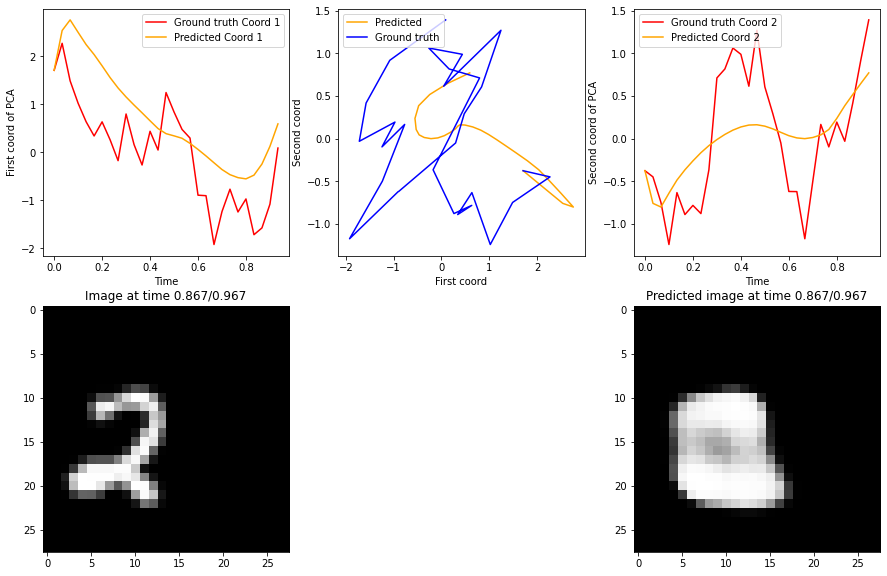

In [12]:
root = None #"images/AE_ODE/Gravity/MultiTrajectories/Together/"
name = None # "conv_ode_1_ball_latent_{}_hidden_ode_{}_stack_{}_conv_activation_{}".format(latent_dim, ode_hidden_dim, stack_size, conv_activation)
display_fn = lambda i, model, out_display, getter, final_time, dt: display_convnode_trajectory(i, model, out_display, getter, final_time, dt, root=root, name=name)
display_fn(0, conv_ode, dynamics_dim, getter, N_frames - Num_pos_velocity, dt)

--------------------------------------------------
Training...


  2%|▏         | 999/50000 [01:45<1:26:18,  9.46it/s, Loss: 0.00427631]

The graphs at epoch 1000


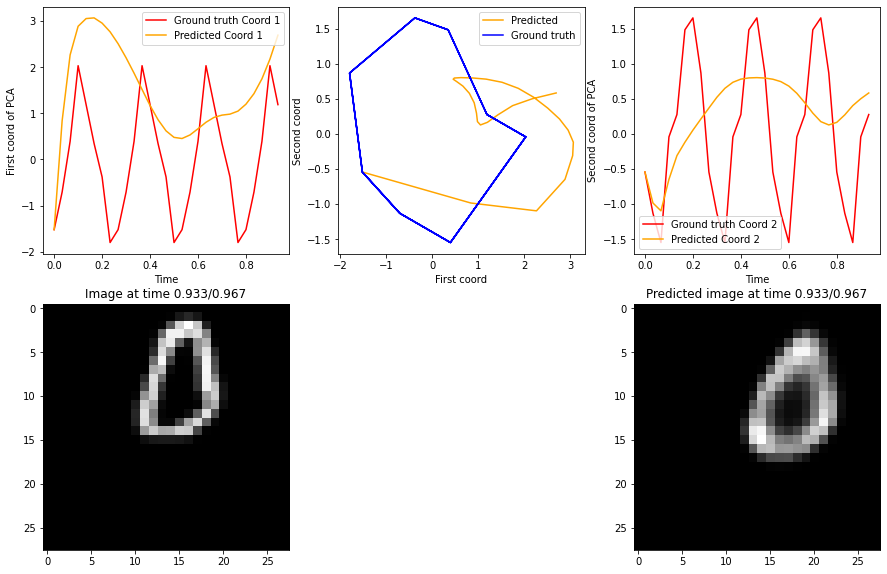

Display loss: 0.00394800:   2%|▏         | 1001/50000 [01:46<2:50:02,  4.80it/s, Loss: 0.00382675]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0042, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(3.2909e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  1e-05
-------------------------------------------------------------------------


Display loss: 0.00394800:   4%|▍         | 1999/50000 [03:32<1:24:57,  9.42it/s, Loss: 0.00397143]

The graphs at epoch 2000


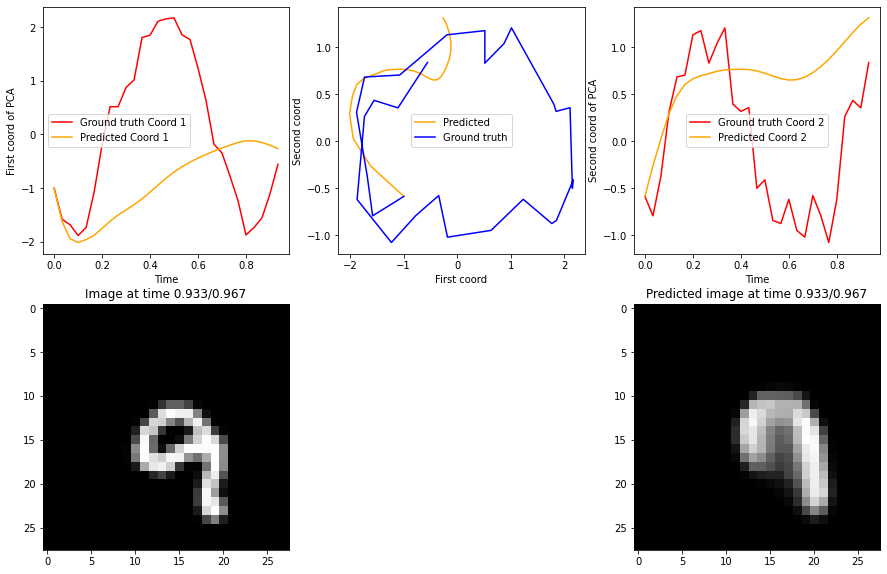

Display loss: 0.00394474:   4%|▍         | 2001/50000 [03:32<2:52:33,  4.64it/s, Loss: 0.00378553]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0039, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(3.2343e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  1e-05
-------------------------------------------------------------------------


Display loss: 0.00394474:   6%|▌         | 2999/50000 [05:18<1:22:39,  9.48it/s, Loss: 0.00426488]

The graphs at epoch 3000


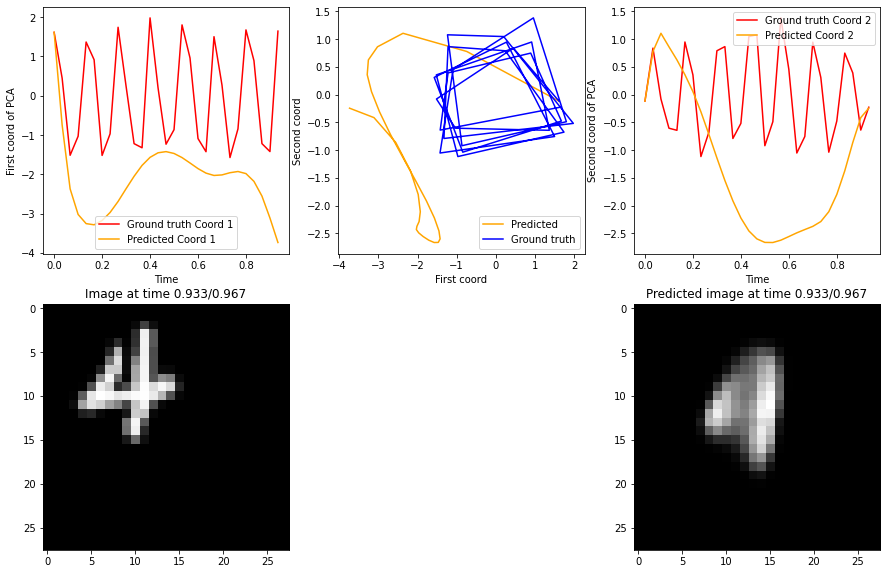

Display loss: 0.00393556:   6%|▌         | 3001/50000 [05:18<2:59:35,  4.36it/s, Loss: 0.00410144]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0042, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(3.3129e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  1e-05
-------------------------------------------------------------------------


Display loss: 0.00393556:   8%|▊         | 3999/50000 [07:04<1:20:11,  9.56it/s, Loss: 0.00358401]

The graphs at epoch 4000


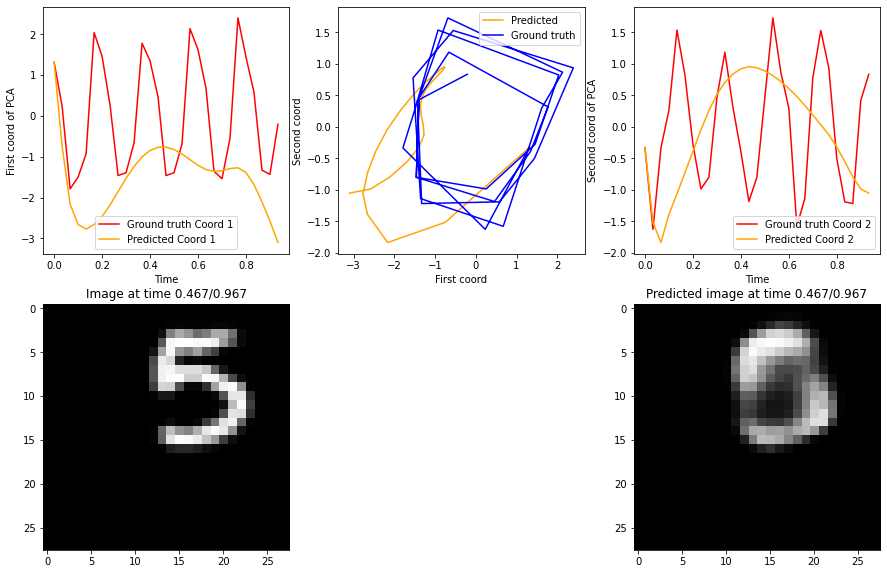

Display loss: 0.00392507:   8%|▊         | 4001/50000 [07:05<2:38:23,  4.84it/s, Loss: 0.00386409]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0036, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(3.2628e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  1e-05
-------------------------------------------------------------------------


Display loss: 0.00392507:  10%|▉         | 4999/50000 [08:50<1:19:24,  9.45it/s, Loss: 0.00370619]

The graphs at epoch 5000


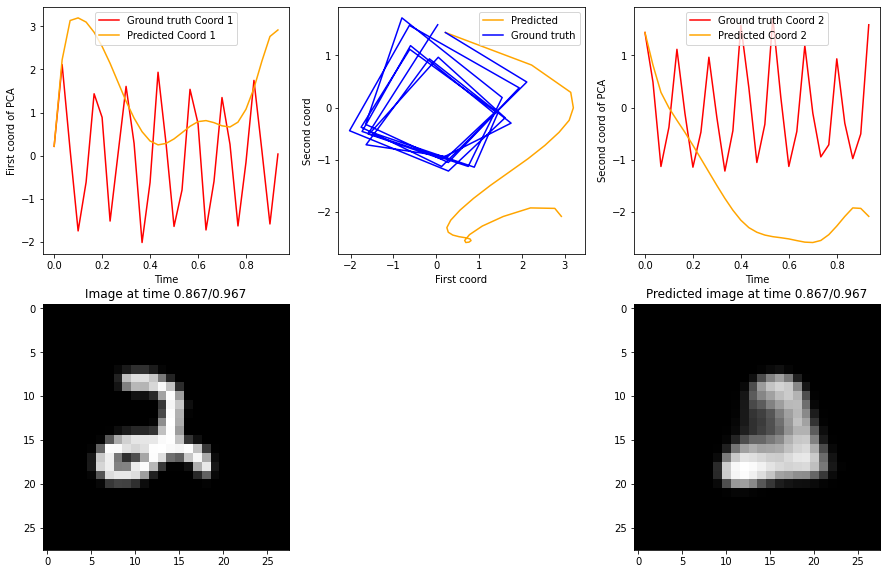

Display loss: 0.00388900:  10%|█         | 5001/50000 [08:51<2:35:59,  4.81it/s, Loss: 0.00416361]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0037, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(3.2769e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  1e-05
-------------------------------------------------------------------------


Display loss: 0.00388900:  12%|█▏        | 5999/50000 [10:37<1:17:40,  9.44it/s, Loss: 0.00470293]

The graphs at epoch 6000


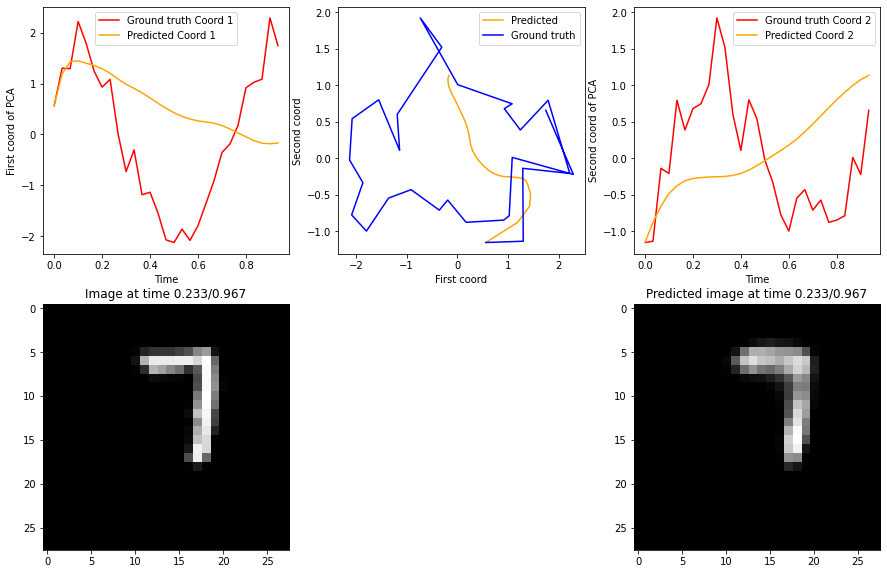

Display loss: 0.00391339:  12%|█▏        | 6001/50000 [10:37<2:30:23,  4.88it/s, Loss: 0.00404323]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0047, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(3.3083e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  1e-05
-------------------------------------------------------------------------


Display loss: 0.00391339:  14%|█▍        | 6999/50000 [12:23<1:16:05,  9.42it/s, Loss: 0.00438004]

The graphs at epoch 7000


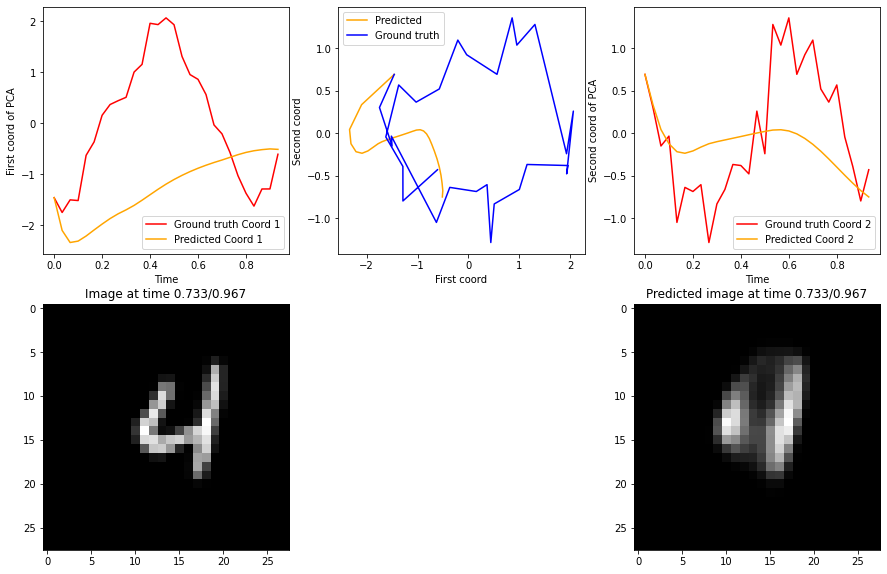

Display loss: 0.00391062:  14%|█▍        | 7001/50000 [12:23<2:26:19,  4.90it/s, Loss: 0.00424338]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0043, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(3.2961e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  1e-05
-------------------------------------------------------------------------


Display loss: 0.00391062:  16%|█▌        | 7999/50000 [14:09<1:14:53,  9.35it/s, Loss: 0.00362261]

The graphs at epoch 8000


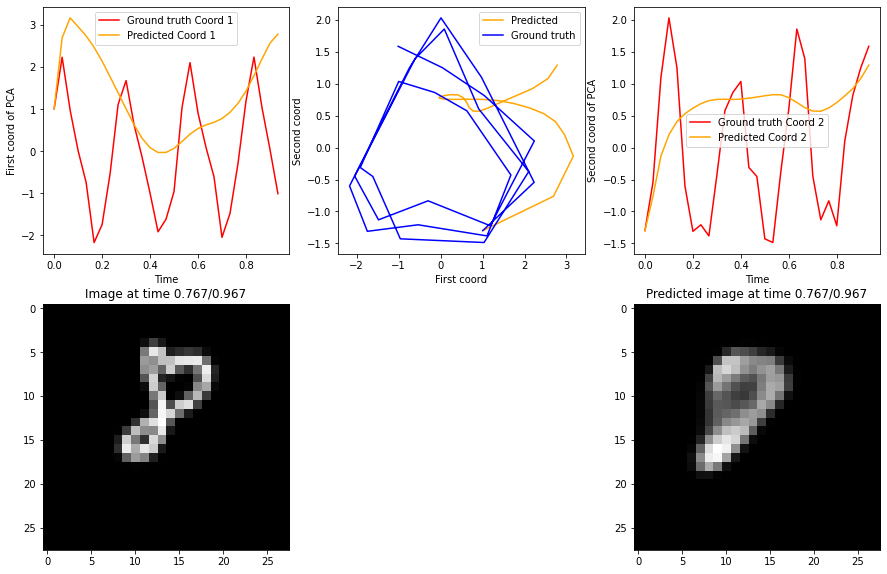

Display loss: 0.00385824:  16%|█▌        | 8001/50000 [14:09<2:27:33,  4.74it/s, Loss: 0.00404085]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0036, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(3.2348e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  1e-05
-------------------------------------------------------------------------


Display loss: 0.00385824:  18%|█▊        | 8999/50000 [15:55<1:11:47,  9.52it/s, Loss: 0.00362847]

The graphs at epoch 9000


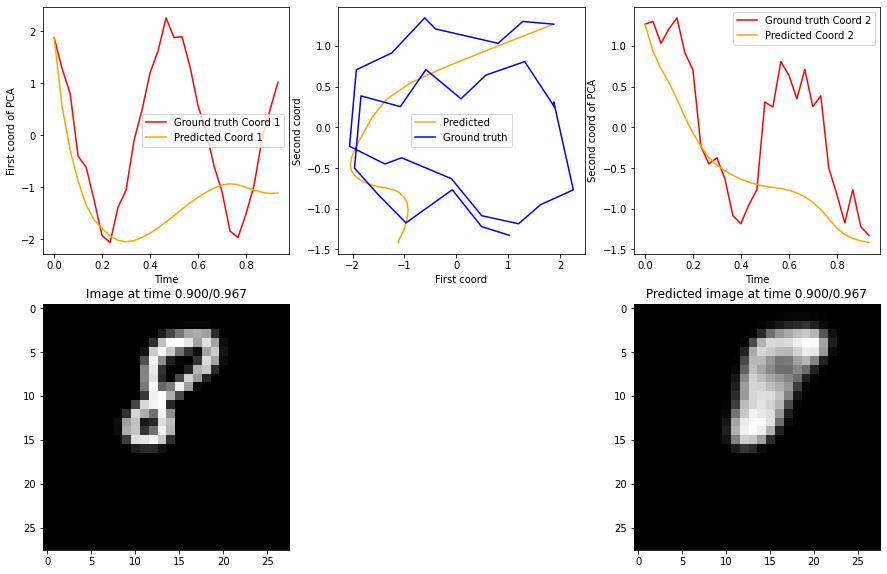

Display loss: 0.00385324:  18%|█▊        | 9001/50000 [15:55<2:25:37,  4.69it/s, Loss: 0.00381799]

------------------------------ Loss prints ------------------------------
loss_img unweighted:  tensor(0.0036, device='cuda:0', grad_fn=<MeanBackward1>)
loss_reg:  tensor(3.2423e-05, device='cuda:0', grad_fn=<MulBackward0>)
reg_lambda:  1e-05
-------------------------------------------------------------------------


Display loss: 0.00385324:  18%|█▊        | 9139/50000 [16:10<1:12:17,  9.42it/s, Loss: 0.00369819]


KeyboardInterrupt: 

In [23]:
print("-"*50)
print("Training...")
epochs = 50000

# for param in conv_ode.node.parameters():
#     param.requires_grad = True


train_convnode_with_batch(conv_ode, optimizers, scheduler, epochs,
    getter, loss_fn=loss_fn, display=1000, display_results_fn=display_fn)

In [24]:
torch.save(conv_ode.state_dict(), "ssh/resnet_modified_ode_one_digit_moving_mnist_dyn_latent_{}_app_dim_{}_hidden_ode_{}_stack_{}_conv_activation_{}.pt".format(dynamics_dim, appearance_dim, ode_hidden_dim, stack_size, conv_activation))

In [25]:
from skimage.color import gray2rgb

def generate_interactive_plot(i, model, out_display, getter, final_time, dt, root=None, name=None):

    index = np.random.randint(0, getter.N_train)
    time_steps = np.linspace(0, final_time*dt, final_time)

    times = torch.arange(0, final_time*dt, dt)

    gd_images = []
    for i in range(len(times)):
        gd_test = getter.train_images[index, i:i+2].unsqueeze(0).to(device)
        gd_test = torch.cat([gd_test[:, 0, 0].unsqueeze(1), gd_test[:, 1, 0].unsqueeze(1), gd_test[:, 1, 1].unsqueeze(1), gd_test[:, 1, 2].unsqueeze(1)], dim=1)
        gd_images.append(gd_test)

    gd_images = torch.stack(gd_images, dim=0).squeeze(1)
    input_images = torch.clone(gd_images[0]).unsqueeze(0).to(device)
    
    gd_images = torch.clone(gd_images).cpu().numpy()
    print(gd_images.shape, input_images.shape)

    # print('input shape', input_images.shape)
    # print('gd shape', gd_images.shape)
    model.eval()
    with torch.no_grad():
        reconstructed_images, _ = model(input_images.to(device), times.to(device), dt)
        reconstructed_images = reconstructed_images.cpu().numpy()[0]

    print("Sim", reconstructed_images.shape, gd_images.shape)

    # gd_images = np.expand_dims(gd_images, axis=1)
    reconstructed_images = np.expand_dims(reconstructed_images[:,0], axis=1)
    print("Extract Gray", gd_images.shape, reconstructed_images.shape)

    gd_images = np.array([gray2rgb(img[0]) for img in gd_images])
    gd_images = 200*(gd_images - gd_images.min())/(gd_images.max() - gd_images.min())
    print("Gray to rgb for gd_images", gd_images.shape, reconstructed_images.shape)

    reconstructed_images = np.array([gray2rgb(img[0]) for img in reconstructed_images])
    reconstructed_images = 200*(reconstructed_images - reconstructed_images.min())/(reconstructed_images.max() - reconstructed_images.min())

    print("Gray to rgb for reconstructed", gd_images.shape, reconstructed_images.shape)

    return interactive_part_trajectory_image_plot(gd_images, reconstructed_images, time_steps, dt)


def interactive_part_trajectory_image_plot(inputs_images, reconstructed_images, time_steps, dt):
    fig = make_subplots(rows=1, cols=3, subplot_titles=("Input image", "Predicted image"))
    fig = go.FigureWidget(fig)
    # add a black background to the figure
    fig.add_image(z=inputs_images[0], row=1, col=1, name='true image')
    fig.add_image(z=reconstructed_images[0], row=1, col=2, name='predicted image')

    N_max_input = len(inputs_images)-1
    N_max_predicted = len(reconstructed_images)-1
    N_max = max(N_max_input, N_max_predicted)

    frac_input = 1. #N_max/N_max_predicted
    frac_predicted = 1. #N_max/N_max_input

    @interact(t=(time_steps.min(),time_steps.max(),dt))
    def update_plot(t=0):
        with fig.batch_update():
            # change the current point of 
            print(t/dt)
            print(int(frac_input*t/dt))
            print(int(frac_predicted*t/dt))
            fig.data[0].z = inputs_images[min(int(frac_input*t/dt), N_max_input)]
            fig.data[1].z = reconstructed_images[min(int(frac_predicted*t/dt), N_max_predicted)]

    return fig

In [28]:
getter_plot = BatchGetterMultiImages(batch_time, batch_size, n_stack, total_length, dt, images_test, frac_train=1.)

In [29]:
fig = generate_interactive_plot(0, conv_ode, 0, getter_plot, int(1.*(N_frames - Num_pos_velocity)), dt, root=None, name=None)
fig

(29, 4, 28, 28) torch.Size([1, 4, 28, 28])
Sim (29, 3, 28, 28) (29, 4, 28, 28)
Extract Gray (29, 4, 28, 28) (29, 1, 28, 28)
Gray to rgb for gd_images (29, 28, 28, 3) (29, 1, 28, 28)
Gray to rgb for reconstructed (29, 28, 28, 3) (29, 28, 28, 3)


interactive(children=(FloatSlider(value=0.4666666666666667, description='t', max=0.9666666666666667, step=0.03…

FigureWidget({
    'data': [{'name': 'true image',
              'type': 'image',
              'uid': 'e1d466…

# Appearance changement

In [34]:
from skimage.color import gray2rgb

def generate_interactive_plot_appearance_swap(i, model, out_display, getter, final_time, dt, root=None, name=None):

    index_dyn = np.random.randint(0, getter.N_train)
    index_app = np.random.randint(0, getter.N_train)
    time_steps = np.linspace(0, final_time*dt, final_time)

    times = torch.arange(0, final_time*dt, dt)

    
    gd_images_dyn = []
    for i in range(len(times)):
        gd_test = getter.train_images[index_dyn, i:i+2].unsqueeze(0).to(device)
        gd_test = torch.cat([gd_test[:, 0, 0].unsqueeze(1), gd_test[:, 1, 0].unsqueeze(1), gd_test[:, 1, 1].unsqueeze(1), gd_test[:, 1, 2].unsqueeze(1)], dim=1)
        gd_images_dyn.append(gd_test)

    gd_images_dyn = torch.stack(gd_images_dyn, dim=0).squeeze(1)
    input_images_dyn = torch.clone(gd_images_dyn[0]).unsqueeze(0).to(device)
    gd_images_dyn = gd_images_dyn.cpu().numpy()

    gd_images_app = []
    for i in range(len(times)):
        gd_test = getter.train_images[index_app, i:i+2].unsqueeze(0).to(device)
        gd_test = torch.cat([gd_test[:, 0, 0].unsqueeze(1), gd_test[:, 1, 0].unsqueeze(1), gd_test[:, 1, 1].unsqueeze(1), gd_test[:, 1, 2].unsqueeze(1)], dim=1)
        gd_images_app.append(gd_test)

    gd_images_app = torch.stack(gd_images_app, dim=0).squeeze(1)
    input_images_app = torch.clone(gd_images_app[0]).unsqueeze(0).to(device)
    gd_images_app = gd_images_app.cpu().numpy()

    
    
    # print('input shape', input_images.shape)
    # print('gd shape', gd_images.shape)
    model.eval()
    with torch.no_grad():
        # reconstructed_images_dyn, _ = model(input_images_dyn.to(device), times.to(device), dt)
        # reconstructed_images_dyn = reconstructed_images_dyn.cpu().numpy()[0]
        
        # reconstructed_images_app, _ = model(input_images_app.to(device), times.to(device), dt)
        # reconstructed_images_app = reconstructed_images_app.cpu().numpy()[0]

        reconstructed_images_transformed, _ = model.forward_diff_appearance(input_images_dyn.to(device), input_images_app.to(device), times.to(device), dt)
        reconstructed_images_transformed = reconstructed_images_transformed.cpu().numpy()[0]
    
    # print("Sim", reconstructed_images.shape, gd_images.shape)


    # reconstructed_images_dyn = np.expand_dims(reconstructed_images_dyn[:,0], axis=1)
    # reconstructed_images_app = np.expand_dims(reconstructed_images_app[:,0], axis=1)
    reconstructed_images_transformed = np.expand_dims(reconstructed_images_transformed[:,0], axis=1)

    
    # print("Extract Gray", gd_images.shape, reconstructed_images.shape)

    gd_images_dyn = np.array([gray2rgb(img[0]) for img in gd_images_dyn])
    gd_images_dyn = 200*(gd_images_dyn - gd_images_dyn.min())/(gd_images_dyn.max() - gd_images_dyn.min())

    gd_images_app = np.array([gray2rgb(img[0]) for img in gd_images_app])
    gd_images_app = 200*(gd_images_app - gd_images_app.min())/(gd_images_app.max() - gd_images_app.min())
    # print("Gray to rgb for gd_images", gd_images.shape, reconstructed_images.shape)

    # reconstructed_images_dyn = np.array([gray2rgb(img[0]) for img in reconstructed_images_dyn])
    # reconstructed_images_dyn = 200*(reconstructed_images_dyn - reconstructed_images_dyn.min())/(reconstructed_images_dyn.max() - reconstructed_images_dyn.min())

    # reconstructed_images_app = np.array([gray2rgb(img[0]) for img in reconstructed_images_app])
    # reconstructed_images_app = 200*(reconstructed_images_app - reconstructed_images_app.min())/(reconstructed_images_app.max() - reconstructed_images_app.min())
    
    reconstructed_images_transformed = np.array([gray2rgb(img[0]) for img in reconstructed_images_transformed])
    reconstructed_images_transformed = 200*(reconstructed_images_transformed - reconstructed_images_transformed.min())/(reconstructed_images_transformed.max() - reconstructed_images_transformed.min())


    # print("Gray to rgb for reconstructed", gd_images.shape, reconstructed_images.shape)

    return interactive_image_plot_appearance_swap(reconstructed_images_transformed, gd_images_dyn, gd_images_app, time_steps, dt)


def interactive_image_plot_appearance_swap(reconstructed_images_transformed, 
                                            gd_images_dyn, gd_images_app, time_steps, dt):
    fig = make_subplots(rows=1, cols=3, subplot_titles=["GT First trajectory", "Dynamic: 1st trajectory | Appearance: 2nd trajectory", "GT Second trajectory"])
    fig = go.FigureWidget(fig)
    # add a black background to the figure
    fig.add_image(z=gd_images_dyn[0], row=1, col=1, name='First trajectory')
    fig.add_image(z=reconstructed_images_transformed[0], row=1, col=2, name='Dynamic: 1st trajectory | Appearance: 2nd trajectory')
    fig.add_image(z=gd_images_app[0], row=1, col=3, name='Second trajectory')


    N_max = len(reconstructed_images_transformed)-1

    # should be initialized at zero
    @interact(t=(time_steps.min(),time_steps.max(),dt), )
    def update_plot(t=0.):
        with fig.batch_update():
            # change the current point of 
            print("float time ration", t/dt)
            print("int time ration", int(t/dt))
            index = min(int(t/dt), N_max)
            fig.data[0].z = gd_images_dyn[index]
            fig.data[1].z = reconstructed_images_transformed[index]
            fig.data[2].z = gd_images_app[index]

    return fig

In [35]:
getter_plot = BatchGetterMultiImages(batch_time, batch_size, n_stack, total_length, dt, images_train, frac_train=1.)

In [36]:
fig = generate_interactive_plot_appearance_swap(0, conv_ode, 0, getter_plot, int(1.*(N_frames - Num_pos_velocity)), dt, root=None, name=None)
fig

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9666666666666667, step=0.03333333333333333…

FigureWidget({
    'data': [{'name': 'First trajectory',
              'type': 'image',
              'uid': '…